In [1]:
from scipy.interpolate import griddata
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import PyIRI
import PyIRI.main_library as ml
from scipy.interpolate import RegularGridInterpolator

In [2]:
#!/usr/bin/env python
# --------------------------------------------------------
# DISTRIBUTION D: Distribution authorized to Department of
# Defense and U.S. DoD contractors only (Critical Technology)
# (28 NOV 2022). Other request for this document shall be referred
# to Commanding Officer, U.S. Naval Research Laboratory.
# --------------------------------------------------------
"""This library contains components for ANCHOR software.

References
----------

Forsythe et al. (2021). Data assimilation retrievalof electron
density profiles fromionosonde virtual height data.
RadioScience, 56, e2021RS007264. doi:10.1029/2021RS007264.

"""



def constants():
    """Define constants for cirtual height calculation.

    Parameters
    ----------
    none

    Returns
    -------
    df: flt
        Increment in frequency in (Hz)
    minf: flt
        Minimum frequency in (Hz)
    epsilon: flt
        How close to 1-X we can get
    dzstep: flt
        Increment in height in (km)
    dphi: flt
        Increment in angle in (deg)
    modeMult: flt
        Mode of signal propagation, +1 for O-mode and −1 for the X-mode
    cp: flt
        Constant that relates plasma frequency to plasma density in Hz m^-1.5
    g_p: flt
        g_p * B is electron gyrofrequency

    Notes
    -----
    This function gives constants for VH.

    """
    df = 0.1e5
    minf = 7e5
    epsilon = 1e-3
    dzstep = 0.01
    dphi = 1e-4
    cp = 8.97866275
    g_p = 2.799249247e10
    return df, minf, epsilon, dzstep, dphi, cp, g_p

def den2freq(density):
    """Convert plasma density to plasma frequency.

    Parameters
    ----------
    density: flt, array-like

    Returns
    -------
    frequency: flt, array-like
        Plasma frequency in (Hz)

    Notes
    -----
    This function converts given plasma density to plasma frequency.

    """
    # Declaring constants
    _, _, _, _, _, cp, _ = constants()
    frequency = np.sqrt(density) * cp
    return frequency

def freq2den(frequency):
    """Convert plasma frequency to plasma density.

    Parameters
    ----------
    frequency: flt, array-like
        Plasma frequency in (Hz)
        
    Returns
    -------
    density: flt, array-like
        Plasma density in (m-3)

    Notes
    -----
    This function converts given plasma frequency to plasma density.

    """
    # Declaring constants
    _, _, _, _, _, cp, _ = constants()
    density = (frequency / cp)**2
    return density


def find_X(n_e, f):
    """Calculate reflection height

    Parameters
    ----------
    n_e: array-like
        Electron density array in (log10 m-3)
    f: array-like
        Frequency of the ionosonde in (Hz)

    Returns
    -------
    X: flt, array-like
        The ratio of the square of the plasma frequency f_N to the 
        square of the ionosonde frequency f.

    Notes
    -----
    This function returns X, the ratio of the square of the plasma frequency
    f_N to the square of the ionosonde frequency f.

    """

    # Load constants
    _, _, _, _, _, cp, _ = constants()
    X = (den2freq(n_e))**2 / f**2
    return X



def find_reflection_height(aalt, n_e, f, epsilon, dzstep):
    """Calculate reflection height

    Parameters
    ----------
    aalt: array-like
        Altitude array in (km)
    n_e: array-like
        Electron density array in (log10 m-3)
    f: array-like
        Frequency of the ionosonde in (Hz)
    epsilon: flt
        Limit, how close to 1-X we want to get
    dzstep: flt
        Increment in height (km)
    Returns
    -------
    density: flt, array-like
        Plasma density in (m-3)

    Notes
    -----
    This function looks for the density of the background that corresponds to the ionosonde frequency and looks for the expected reflection height

    """
    if n_e.size != aalt.size:
        print('Array of density does not have the same number of elements as the array of corresponding heights')
        stop 
    # Declaring constants
    df, minf, epsilon, dzstep, dphi, cp, g_p = constants()
    zvalues = aalt
    ztest = zvalues[0]
    densr = f**2 / cp**2
    nVertical = aalt.size
    maxX = np.max(n_e) * cp**2 / f**2
    htIndMax = 0.
    for k in range(0, nVertical):
        if (n_e[k] >= np.max(n_e)):
            htIndMax = k
    if (htIndMax == (nVertical - 1)):
        htIndMax = htIndMax - 1
    if (maxX < 1):
        zreflec = zvalues[htIndMax]
    else:
        ztest = zvalues[0]
    X = find_X(n_e[0], f)
    if (X >= (1. - epsilon)):
        zreflec = zvalues[0]
    else:
        while (X < (1.0 - epsilon)) & (ztest <= zvalues[nVertical - 1]):
            ztest = ztest + dzstep
            intval = np.interp(ztest, zvalues, n_e)
            X = find_X(intval, f)
        zreflec = ztest - dzstep
    return zreflec


def AH(X, Y, btheta, modeMult):
    """Calculate group refractive index 

    Parameters
    ----------
    X: array-like
        Ratio of plasma and emission frequncies
    Y: array-like
        Ratio of electron gyrofrequency and emission frequency 
    btheta: array-like
        Angle of the magnetic field in (deg)
    modeMult: flt
        Mode of signal propagation, +1 for O-mode and −1 for the X-mode
        
    Returns
    -------
    mup: array-like
        Group refractive index 
    mu: array-like
        Phase refractive index
    Notes
    -----
    This function calculates the group and phase refractive index 

    """
    YT = Y * np.sin(np.deg2rad(btheta))
    YL = Y * np.cos(np.deg2rad(btheta))
    Xm1 = 1. - X
    alpha = 0.25 * YT**4 + YL**2 * Xm1**2
    beta = np.sqrt(alpha)
    D = Xm1 - 0.5 * YT**2 + modeMult * beta
    mu = np.sqrt(1. - X * Xm1 / D)
    dbetadX = -YL**2 * Xm1 / beta
    dDdX = -1. + modeMult * dbetadX
    dalphadY = (YT**3 * np.sin(np.deg2rad(btheta))) + (2. * YL * Xm1**2 * np.cos(np.deg2rad(btheta)))
    dbetadY = 0.5 * dalphadY / beta
    dDdY = -YT * np.sin(np.deg2rad(btheta)) + modeMult * dbetadY
    dmudY = (X * Xm1 * dDdY) / (2. * mu * D**2)
    dmudX = (1. / (2. * mu * D)) * (2. * X - 1. + X * Xm1 / D * dDdX)
    mup = mu - (2. * X * dmudX + Y * dmudY)
    return mup, mu


def find_virtual_height(f, zvalues, zreflec, n_e, b, theta, epsilon, dphi, modeMult):
    """Calculate group refractive index 

    Parameters
    ----------
    f: flt
        Ionosonde frequency in (Hz)
    zvalues: array-like
        Altitude array in (km)
    zreflec: array-like
        Reflection height in (km)
    n_e: array-like
        Electron density in (m-3)
    b: array-like
        Magnetic field strength
    theta: array-like
        Magnetic field angle (dip?)
    epsilon: flt
        Limit, how close to 1-X we want to get
    dphi: flt
        Increment in angle in (deg)
    modeMult: flt
        Mode of signal propagation, +1 for O-mode and −1 for the X-mode

    Returns
    -------
    vhval: flt
        Virtual height in (km)
        
    Notes
    -----
    This function calculates virtual height for the vertical ionosonde signal

    """
    df, minf, epsilon, dzstep, dphi, cp, g_p = constants()
    phi = np.arcsin(np.sqrt(zvalues[0] / zreflec))
    ztest = zvalues[0]
    X = find_X(n_e[0], f)
    vhval = zvalues[0]
    while (X <= (1. - epsilon)) & (phi <= (np.pi / 2.)):
        dh = 2. * zreflec * np.sin(phi) * np.cos(phi) * dphi
        b0 = np.interp(ztest, zvalues, b)
        Y = g_p * b0 / f
        n_e0 = np.interp(ztest, zvalues, n_e)
        theta0 = np.interp(ztest, zvalues, theta)
        mup, mu = AH(X, Y, theta0, modeMult)
        ztest = zreflec * np.sin(phi)**2
        vhval = vhval + mup * dh
        X = find_X(n_e0, f)
        phi = phi + dphi

    return vhval


def VH_forward_operator(x, altitude, ion_freq, abmag, atheta, mode):
    """Calculate virtual height for all frequencies 

    Parameters
    ----------
    x: array-like
        Electrond ensity array (log10 m-3)
    altitude: array-like
        Altitude array in (km)
    ion_freq: array-like
        Ionosonde frequency in (Hz)
    abmag: array-like
        Magnetic field strength
    atheta: array-like
        Magnetic field angle

    Returns
    -------
    virt_height: array-like
        Virtual height in (km)
        
    Notes
    -----
    This function calculates virtual height for the vertical ionosonde signal

    """
    # Pick the mode
    if mode == 'O':
        modeMult = 1
    if mode == 'X':
        modeMult = -1

    # Declaring constants
    df, minf, epsilon, dzstep, dphi, cp, g_p = constants()
  
    n_e = 10**x
    f_t = den2freq(n_e)

    ion_den = freq2den(ion_freq)
    virt_height = np.empty((ion_freq.size))
    max_freq = den2freq(np.max(n_e))

    for i in range(0, ion_freq.size):
        f = ion_freq[i]
        if f <= max_freq:
            zreflec = find_reflection_height(altitude, n_e, f, epsilon, dzstep)
            vhval = find_virtual_height(f, altitude, zreflec, n_e, abmag, atheta, epsilon, dphi, modeMult)
            virt_height[i] = vhval

    return virt_height






In [3]:
# EXAMPLE:
# Let's take EDP from PyIRI
year = 2020
month = 4
day = 1
ahr = np.array([10])
alon = np.array([0])
alat = np.array([0])
aalt = np.arange(90, 500, 1)
f107 = 100
ccir_or_ursi = 0
f2, f1, e_peak, es_peak, sun, mag, edp = ml.IRI_density_1day(year, month, day, ahr, alon, alat, aalt, f107, PyIRI.coeff_dir, ccir_or_ursi)

ionosphere_density = edp[0, :, 0]

# Convert density to frequency 
ionosphere_frequency = den2freq(ionosphere_density)

# The input for VH_forward_operator should be in log10 of density
density_in = np.log10(ionosphere_density)

# Find max ionospheric density to know the max ionosonde frequency 
NmF2 = np.max(ionosphere_density)

# This will be max of ionosonde frequency 
foF2 = den2freq(NmF2)

# Array of ionosonde frequency, in real life this will be given 
ionosonde_frequency = np.arange(7e5, foF2, 0.1e6)

# Ionosonde density, this is just for plotting density and frequency on the same axis
ionosonde_density = freq2den(ionosonde_frequency)

# You will need to find those arrays for your location using Apex (or whatever you prefer for magnetic field information)
# I just make those arrays as place holders
atheta = np.zeros((aalt.size)) + 89.
abmag = np.zeros((aalt.size)) + 2.5e-5

virtual_height = VH_forward_operator(density_in, aalt, ionosonde_frequency, abmag, atheta, mode='O')





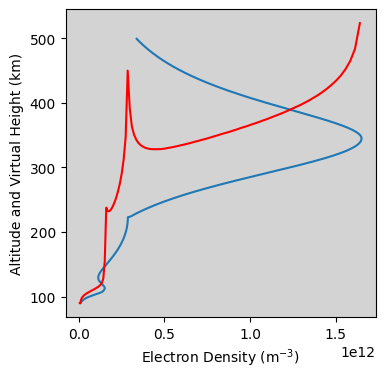

In [4]:
# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.plot(ionosphere_density, aalt)
ax.plot(ionosonde_density, virtual_height, c='red')


ionosonde_frequency= (109,)
ionosphere_density= (255,)
den= (109, 255)
freq_2d= (109, 255)
b_2d= (109, 255)
alt_grid_2d= (109, 255)
freq_grid_2d= (109, 255)
[ 90.          90.          90.          92.42875797  94.22287877
  95.90202273  97.63331101  99.58075371 102.16902763 111.15789062
 101.5890873  104.21408668 114.21365755 104.32293225 107.80868423
 105.01433846 107.80711893 118.46138902 108.43944301 112.92533192
 109.2843509  112.55758633 123.74124025 112.85982976 180.41932196
 205.489781   211.55791061 226.26151159 272.18417306 235.52393506
 232.51548758 233.45445935 234.11357188 234.19961811 248.05017448
 260.8985582  263.38734098 282.82424394 286.06001529 316.65299713
 365.64308565 467.31159546 388.9110206  379.06560653 345.97377844
 340.85058483 340.13846324 352.55433081 328.1617134  331.24487221
 348.34963194 325.3891912  331.95774132 322.78664284 328.42840897
 373.4284036  327.59337356 345.93009769 328.26446796 345.41602574
 330.04036008 351.60903337 332.78097484 432.5305471

/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_23741/987727875.py:90: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1. - X * Xm1 / D)


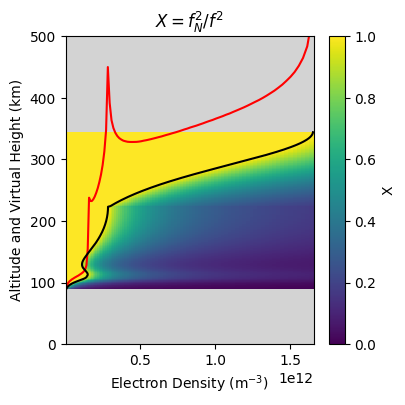

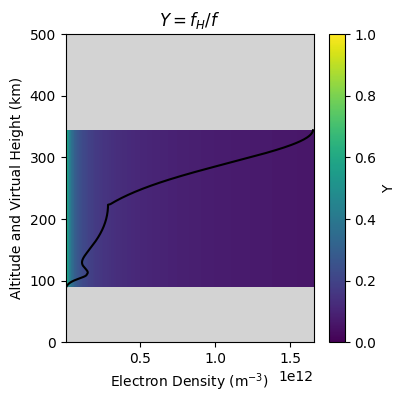

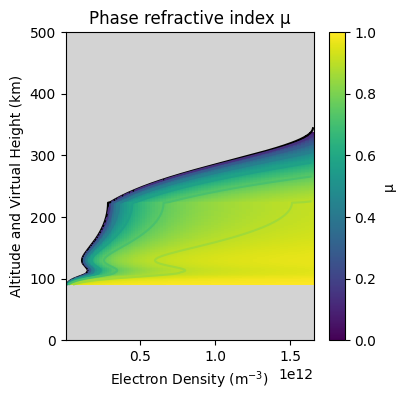

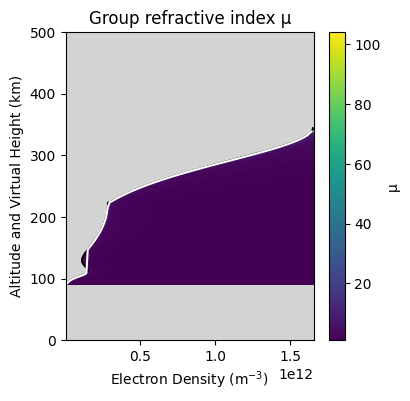

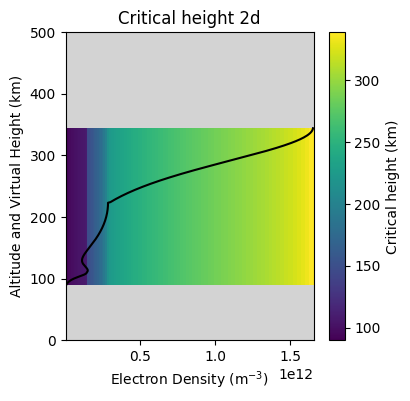

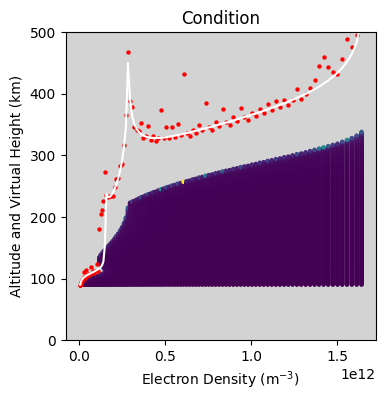

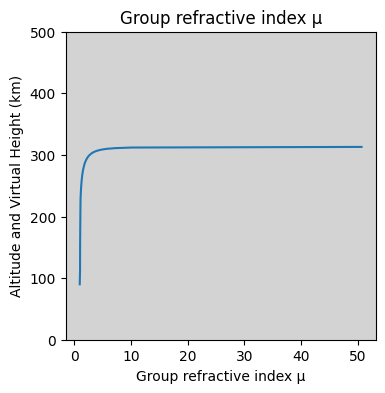

In [5]:


def find_X(n_e, f):
    """Calculate reflection height

    Parameters
    ----------
    n_e: array-like
        Electron density array in (log10 m-3)
    f: array-like
        Frequency of the ionosonde in (Hz)

    Returns
    -------
    X: flt, array-like
        The ratio of the square of the plasma frequency f_N to the 
        square of the ionosonde frequency f.

    Notes
    -----
    This function returns X, the ratio of the square of the plasma frequency
    f_N to the square of the ionosonde frequency f.

    """

    # Load constants
    _, _, _, _, _, cp, _ = constants()
    X = (den2freq(n_e))**2 / f**(2)

    return X


def find_Y(f, b):
    """Calculate the gyrofrequency to the ionosonde frequency ratio

    Parameters
    ----------
    f: array-like
        Ionosonde frequency in Hz
    b: array-like
        Magnitude of the magnetic field
        
    Returns
    -------
    Y: array-like
        Group refractive index 

    Notes
    -----
    This function calculates the ratio of electron gyrofrequency and the 
    ionosonde frequency

    """
    _, _, _, _, _, _, g_p = constants()
    Y = g_p * b / f
    return Y


def find_mu(X, Y, bpsi, modeMult):
    """Calculate group refractive index 

    Parameters
    ----------
    X: array-like
        Ratio of plasma and emission frequncies
    Y: array-like
        Ratio of electron gyrofrequency and emission frequency 
    bpsi: array-like
        The angle ψ between the wave vector and the Earth's magnetic field.
    modeMult: flt
        Mode of signal propagation, +1 for O-mode and −1 for the X-mode
        
    Returns
    -------
    mu: array-like
        Phase refractive index μ
    mup: array-like
        Group refractive index μ′

    Notes
    -----
    This function calculates the phase refractive index μ and the group
    refractive index μ′

    """
    YT = Y * np.sin(np.deg2rad(bpsi))
    YL = Y * np.cos(np.deg2rad(bpsi))
    Xm1 = 1. - X
    alpha = 0.25 * YT**4 + YL**2 * Xm1**2
    beta = np.sqrt(alpha)
    D = Xm1 - 0.5 * YT**2 + modeMult * beta
    mu = np.sqrt(1. - X * Xm1 / D)

    dbetadX = -YL**2 * Xm1 / beta
    dDdX = -1. + modeMult * dbetadX
    dalphadY = (YT**3 * np.sin(np.deg2rad(bpsi))) + (2. * YL * Xm1**2 * np.cos(np.deg2rad(bpsi)))
    dbetadY = 0.5 * dalphadY / beta
    dDdY = -YT * np.sin(np.deg2rad(bpsi)) + modeMult * dbetadY
    dmudY = (X * Xm1 * dDdY) / (2. * mu * D**2)
    dmudX = (1. / (2. * mu * D)) * (2. * X - 1. + X * Xm1 / D * dDdX)
    mup = mu - (2. * X * dmudX + Y * dmudY)

    return mu, mup


# EXAMPLE:
# Let's take EDP from PyIRI
year = 2020
month = 4
day = 1
ahr = np.array([10])
alon = np.array([0])
alat = np.array([0])
dh = 1
aalt = np.arange(90, 500, dh)
f107 = 100
ccir_or_ursi = 0
f2, f1, e_peak, es_peak, sun, mag, edp = ml.IRI_density_1day(year, month, day, ahr, alon, alat, aalt, f107, PyIRI.coeff_dir, ccir_or_ursi)


ind = np.where(aalt < f2['hm'][0, 0])[0]
aalt = aalt[ind]
ionosphere_density = np.reshape(edp[0, ind, 0], ind.size)


# Convert density to frequency 
ionosphere_frequency = den2freq(ionosphere_density)

# The input for VH_forward_operator should be in log10 of density
density_in = np.log10(ionosphere_density)

# Find max ionospheric density to know the max ionosonde frequency 
NmF2 = np.max(ionosphere_density)

# This will be max of ionosonde frequency 
foF2 = den2freq(NmF2)

# Array of ionosonde frequency, in real life this will be given 
ionosonde_frequency = np.arange(7e5, foF2, 0.1e6)

# Ionosonde density, this is just for plotting density and frequency on the same axis
ionosonde_density = freq2den(ionosonde_frequency)

# You will need to find those arrays for your location using Apex (or whatever you prefer for magnetic field information)
# I just make those arrays as place holders
atheta = np.zeros((aalt.size)) + 89.
abmag = np.zeros((aalt.size)) + 2.5e-5
mode = 'O'

# Pick the mode
if mode == 'O':
    modeMult = 1
if mode == 'X':
    modeMult = -1

den_2d = np.full((ionosonde_frequency.size, ionosphere_density.size), ionosphere_density)
b_2d = np.full((ionosonde_frequency.size, ionosphere_density.size), abmag)
psi_2d = np.full((ionosonde_frequency.size, ionosphere_density.size), atheta)
freq_2d = np.transpose(np.full((ionosphere_density.size, ionosonde_frequency.size), ionosonde_frequency))
alt_grid_2d, freq_grid_2d = np.meshgrid(aalt, ionosonde_frequency)
den_grid_2d = freq2den(freq_grid_2d)


print('ionosonde_frequency=', ionosonde_frequency.shape)
print('ionosphere_density=', ionosphere_density.shape)
print('den=', den_2d.shape)
print('freq_2d=', freq_2d.shape)
print('b_2d=', b_2d.shape)
print('alt_grid_2d=', alt_grid_2d.shape)
print('freq_grid_2d=', freq_grid_2d.shape)

aX = find_X(den_2d, freq_2d)
aY = find_Y(freq_2d, b_2d)
mu, mu_prime = find_mu(aX, aY, psi_2d, modeMult)


ind_max = np.argmax(ionosphere_frequency) + 1
ionosphere_frequency_llimited = ionosphere_frequency[0: ind_max]
aalt_llimited = aalt[0: ind_max]

critical_height = np.interp(ionosonde_frequency, ionosphere_frequency_llimited, aalt_llimited)
critical_height_2d = np.transpose(np.full((ionosphere_density.size, ionosonde_frequency.size), critical_height))


# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('$X = f_N^2/f^2$')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.set_ylim([0, 500])
ax.plot(ionosonde_density, virtual_height, c='red')
# a = np.where(aX > 1.)
# aX[a] = np.nan
mesh = ax.pcolormesh(den_grid_2d, alt_grid_2d, aX, vmin=0, vmax=1)
ax.plot(ionosphere_density, aalt, c='black')
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('X')

# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('$Y = f_H/f$')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.plot(ionosphere_density, aalt, c='black')
ax.set_ylim([0, 500])
mesh = ax.pcolormesh(den_grid_2d, alt_grid_2d, aY, vmin=0, vmax=1)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Y')


# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Phase refractive index μ')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.plot(ionosphere_density, aalt, c='black')
ax.set_ylim([0, 500])
mesh = ax.pcolormesh(den_grid_2d, alt_grid_2d, mu, vmin=0, vmax=1)
ax.contour(den_grid_2d, alt_grid_2d, mu)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('μ')


# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Group refractive index μ')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.plot(ionosphere_density, aalt, c='black')
ax.set_ylim([0, 500])
mesh = ax.pcolormesh(den_grid_2d, alt_grid_2d, mu_prime)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('μ')
ax.plot(ionosonde_density, critical_height, c='white')

# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Critical height 2d')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.plot(ionosphere_density, aalt, c='black')
ax.set_ylim([0, 500])
mesh = ax.pcolormesh(den_grid_2d, alt_grid_2d, critical_height_2d)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Critical height (km)')


# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Condition')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
ax.set_ylim([0, 500])

ax.scatter(den_grid_2d, alt_grid_2d, c=mu_prime, linewidth=0, s=10)


vh = np.nansum(mu_prime, axis=1) * dh + np.min(aalt)
ax.plot(ionosonde_density, virtual_height, c='white')
ax.scatter(ionosonde_density, vh, c='red', linewidth=0, s=10)
print(vh)

# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Group refractive index μ')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Group refractive index μ')
ax.set_ylim([0, 500])
ax.plot(mu_prime[100, :], aalt)











multiplier.shape= (50,)
multiplier_2d.shape= (109, 50)
critical_height_2d.shape= (109, 50)
new_alt_2d.shape= (109, 50)
new_ind_2d.shape= (109, 50)
critical_height.shape= (109,)
den_2d.shape= (109, 255)


NameError: name 'stretch_array' is not defined

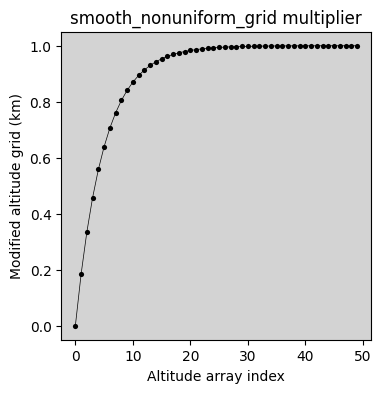

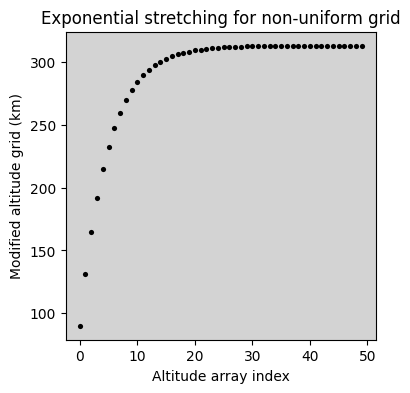

In [6]:

# We use an exponential stretching transformation to generate a non-uniform grid with progressively finer resolution toward one boundary, following methods described in standard numerical modeling literature (e.g., Ferziger & Perić, 2002).

def smooth_nonuniform_grid(start, end, n_points, sharpness):
    """
    Generate a smooth non-uniform grid between `start` and `end`,
    where the resolution gradually increases toward the `end` point.

    The grid starts with coarse spacing near `start` and transitions 
    smoothly to finer spacing near `end`, controlled by the `sharpness`
    parameter.

    Parameters
    ----------
    start : float
        Starting value of the grid.
    end : float
        Ending value of the grid.
    n_points : int
        Number of grid points to generate.
    sharpness : float
        Controls how quickly the resolution transitions; higher values make
        the resolution change more abrupt.

    Returns
    -------
    x : ndarray
        1-D numpy array of grid points with smooth, non-uniform spacing.

    Notes
    -----
    The method uses an exponential transformation of a uniform grid
    to achieve non-uniformity. 
    """

    # Uniform grid [0, 1]
    u = np.linspace(0.0, 1.0, n_points)
    # Flip to make fine resolution near 'end'
    flipped_u = 1.0 - u
    factor = (np.exp(sharpness * flipped_u) - 1.0) / (np.exp(sharpness) - 1.0)
    x = 1. - (start + (end - start) * factor)
    return x


start = 0.
end = 1.
n_points = 50
sharpness = 10
multiplier = smooth_nonuniform_grid(start, end, n_points, sharpness)


multiplier_2d = np.full((critical_height.size, multiplier.size), multiplier)
critical_height_2d = np.transpose(np.full((multiplier.size, critical_height.size), critical_height))

index = np.arange(0, multiplier.size, 1)

new_alt_2d = multiplier_2d * (critical_height_2d - aalt[0]) + aalt[0]
new_ind_2d = np.full((critical_height.size, index.size), index)

print('multiplier.shape=', multiplier.shape)
print('multiplier_2d.shape=', multiplier_2d.shape)
print('critical_height_2d.shape=', critical_height_2d.shape)
print('new_alt_2d.shape=', new_alt_2d.shape)
print('new_ind_2d.shape=', new_ind_2d.shape)
print('critical_height.shape=', critical_height.shape)
print('den_2d.shape=', den_2d.shape)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('smooth_nonuniform_grid multiplier')
ax.set_facecolor("lightgray")
ax.set_ylabel('Modified altitude grid (km)')
ax.set_xlabel('Altitude array index')
ax.plot(index, multiplier, c='black', linewidth=0.5)
ax.scatter(index, multiplier, c='black', s=14, linewidths=0)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Exponential stretching for non-uniform grid')
ax.set_facecolor("lightgray")
ax.set_ylabel('Modified altitude grid (km)')
ax.set_xlabel('Altitude array index')
i = 100
ax.scatter(index, new_alt_2d[i, :], c='black', s=14, linewidths=0)
ax.plot([0, stretch_array.size], [critical_height[i], critical_height[i]], '--', c='red')
ax.text(0, critical_height[i] + 2, 'Critical height', c='red')


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('All new altitude arrays')
ax.set_facecolor("lightgray")
ax.set_ylabel('Modified altitude grid (km)')
ax.set_xlabel('Altitude array index')
for i in range(0, critical_height.size):
    ax.plot(index, new_alt_2d[i, :], linewidth=0.5, c='black')


# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('Density')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Index')
ax.set_ylim([0, 500])
ax.scatter(new_ind_2d, new_alt_2d, c=values, linewidth=0, s=1, vmin=0, vmax=2e12)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Density')







# It is more efficient to interpolate in 1-D using numpy, but we need to make a
# big flat array of new altitudes instead of looping through each column, then
# we can reshape to the original shape

# Flattened array of new altitudes where we want to sample the density profile
new_alt_1d = np.reshape(new_alt_2d, new_ind_2d.size)

den_mod = np.reshape(np.interp(new_alt_1d, aalt, ionosphere_density), new_alt_2d.shape)
bmag_mod = np.reshape(np.interp(new_alt_1d, aalt, abmag), new_alt_2d.shape)
bpsi_mod = np.reshape(np.interp(new_alt_1d, aalt, atheta), new_alt_2d.shape)

ionosonde_freq_mod = np.transpose(np.full((index.size, ionosonde_frequency.size), ionosonde_frequency))


aX = find_X(den_mod, ionosonde_freq_mod)
aY = find_Y(ionosonde_freq_mod, bmag_mod)
mu, mu_prime = find_mu(aX, aY, bpsi_mod, modeMult)


x_plot = index
y_plot = ionosonde_frequency

ax_plot, ay_plot = np.meshgrid(x_plot, y_plot)

# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('$X = f_N^2/f^2$')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
mesh = ax.pcolormesh(ax_plot, ay_plot, aX, vmin=0, vmax=1)

print(np.max(aX))






# No we apply the forward operator to find virtual height
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.set_title('$X = f_N^2/f^2$')
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude and Virtual Height (km)')
ax.set_xlabel('Electron Density (m$^{-3}$)')
mesh = ax.pcolormesh(ax_plot, ay_plot, new_alt_2d, vmin=110, vmax=360)